In [5]:
import pandas as pd
import numpy as np
import sys
import os

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import plotly.express as px #Plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#GLM == General Linear Models
import scipy
import statsmodels
import seaborn as sns
from scipy.stats import zscore
#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
df_txt = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)
print(df_txt)

                                                       0
0      Hugo_Symbol\tEntrez_Gene_Id\tTCGA-A1-A0SB-01\t...
1      UBE2Q2P2\t100134869\t14.3935\t11.3241\t4.4426\...
2      HMGB1P1\t10357\t116.3870\t60.2630\t153.1452\t1...
3      LOC155060\t155060\t279.7612\t83.6986\t74.7018\...
4      RNU12-2P\t26823\t0.4505\t0.3308\t0.0000\t0.000...
...                                                  ...
20436  ZYX\t7791\t6186.7327\t3559.6725\t3007.8157\t53...
20437  ZZEF1\t23140\t1931.2986\t1278.9678\t926.3677\t...
20438  ZZZ3\t26009\t1436.1978\t1195.6000\t1075.4422\t...
20439  TPTEP1\t387590\t552.3144\t86.0144\t866.1456\t5...
20440  AKR1C6P\t389932\t0.0000\t0.0000\t0.0000\t0.856...

[20441 rows x 1 columns]


In [7]:
df_csv = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")
print(df_csv.columns)


Shape of the CSV: (20440, 819)
Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01',
       'TCGA-A1-A0SE-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SH-01',
       'TCGA-A1-A0SI-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SK-01',
       ...
       'TCGA-LL-A5YM-01', 'TCGA-LL-A5YN-01', 'TCGA-LL-A5YO-01',
       'TCGA-LL-A5YP-01', 'TCGA-LQ-A4E4-01', 'TCGA-MS-A51U-01',
       'TCGA-OL-A66H-01', 'TCGA-OL-A66I-01', 'TCGA-OL-A66J-01',
       'TCGA-OL-A66K-01'],
      dtype='object', length=819)


In [10]:
Important_Genes = ['ERBB2', 'ESR1', 'PGR', 'MKI67']
df_genes = df_csv[df_csv['Hugo_Symbol'].isin(Important_Genes)].copy()
df_genes = df_genes.set_index('Hugo_Symbol').T
print(df_genes.shape)
print(df_genes.columns)

(818, 4)
Index(['ERBB2', 'ESR1', 'MKI67', 'PGR'], dtype='object', name='Hugo_Symbol')


In [11]:
print(f"Genes: {df_genes.shape[0]}, Samples: {df_genes.shape[1]}")

Genes: 818, Samples: 4


In [12]:
print(f"Before the 0 elimination: {df_genes.shape[1]}")
#df_genes = df_genes.loc[:, ~(df_genes == 0).any(axis=0)]

"""
Max, avg, median, min of zeros
"""
max_number_of_zeros = (df_genes == 0).sum(axis=0).max()
avg_number_of_zeros = (df_genes == 0).sum(axis=0).mean()
median_number_of_zeros = (df_genes == 0).sum(axis=0).median()
min_number_of_zeros = (df_genes == 0).sum(axis=0).min()
print(f"Max of zeros per row in the dataset: {max_number_of_zeros}")
print(f"Avg of zeros per row in the dataset: {avg_number_of_zeros}")
print(f"Median of zeros per row in the dataset: {median_number_of_zeros}")
print(f"Min of zeros per row in the dataset: {min_number_of_zeros}")
df_genes = df_genes.loc[:, (df_genes > 0).sum(axis=0) >= 500] 
print(f"After the 0 elimination: {df_genes.shape[1]}")


Before the 0 elimination: 4
Max of zeros per row in the dataset: 1
Avg of zeros per row in the dataset: 0.25
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 4


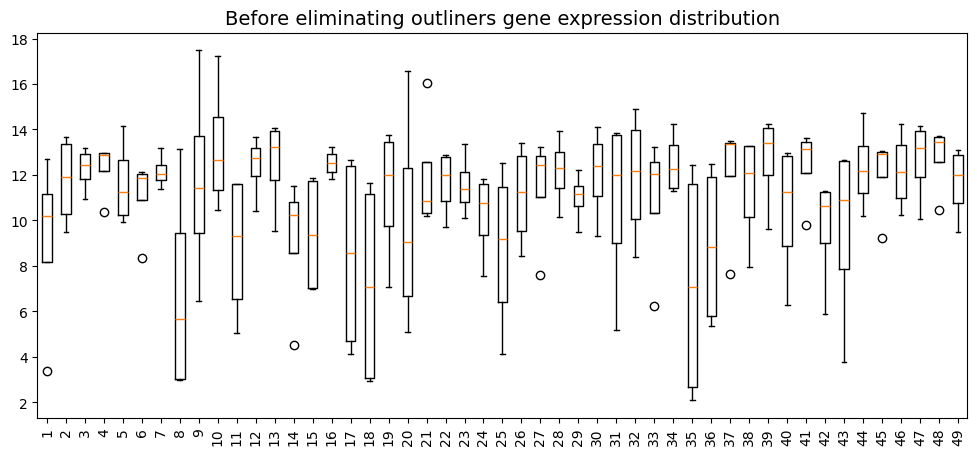

In [13]:
plt.figure(figsize=(12,5))
plt.boxplot(np.log2(df_genes[1:50].T + 1))  # transpose
plt.title("Before eliminating outliners gene expression distribution", fontsize=14)
plt.xticks(rotation=90)
plt.show()

0.0
18.366303811569544
11.137827758111447


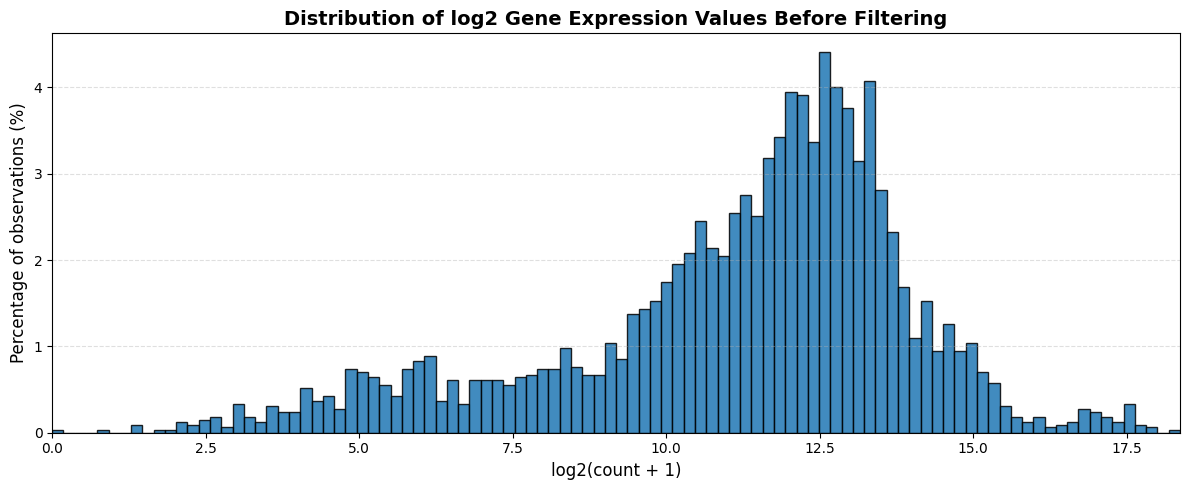

In [14]:
print(np.min(np.log2(df_genes.values + 1)))
print(np.max(np.log2(df_genes.values + 1)))
print(np.mean(np.log2(df_genes.values + 1)))

x = np.log2(df_genes.iloc[1:2000].T.values.flatten() + 1)
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values Before Filtering",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_prep = df_csv.set_index('Hugo_Symbol').drop(columns=['Entrez_Gene_Id'], errors='ignore')

# TRANSPONEMOS: Ahora las filas son Pacientes y las columnas son Genes
df_counts = df_prep.T

# SOLUCIÓN AL ERROR: Convertimos nombres de columnas a string y limpiamos espacios
df_counts.columns = df_counts.columns.astype(str).str.strip()

# --- 2. VERIFICACIÓN DE GENES ---
Important_Genes = ['ERBB2', 'ESR1', 'PGR', 'MKI67']
# Filtramos solo los que realmente existan en el dataset para evitar KeyErrors
genes_existentes = [g for g in Important_Genes if g in df_counts.columns]
print(f"Genes encontrados para clasificar: {genes_existentes}")

# --- 3. ESCALADO Y PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_counts)

pca_obj = PCA(n_components=4)
components = pca_obj.fit_transform(X_scaled)

# --- 4. LÓGICA DE CLASIFICACIÓN ---
def clasificar(row):
    # Usamos .get para que si falta un gen, no rompa el código
    her2 = row.get('ERBB2', 0)
    esr1 = row.get('ESR1', 0)
    ki67 = row.get('MKI67', 0)
    
    # Clasificación basada en la mediana de cada gen
    if her2 > df_counts['ERBB2'].median() if 'ERBB2' in df_counts else 0:
        return 'HER2-Enriched'
    elif esr1 > df_counts['ESR1'].median() if 'ESR1' in df_counts else 0:
        if ki67 > df_counts['MKI67'].median() if 'MKI67' in df_counts else 0:
            return 'Luminal B'
        else:
            return 'Luminal A'
    else:
        return 'Triple Negativo'

# Aplicamos la clasificación
subtypes = df_counts.apply(clasificar, axis=1)

# --- 5. GRÁFICO FINAL ---
df_plot = pd.DataFrame(components, columns=['0', '1', '2', '3'])
df_plot['Subtype'] = subtypes.values
df_plot['Patient_ID'] = df_counts.index

labels = {str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca_obj.explained_variance_ratio_ * 100)}

fig = px.scatter_matrix(
    df_plot,
    dimensions=['0', '1', '2', '3'],
    color='Subtype',
    labels=labels,
    hover_name='Patient_ID',
    title="PCA of type in cancer",
    color_discrete_map={
        'Luminal A': '#1f77b4', 'Luminal B': '#aec7e8',
        'HER2-Enriched': '#ff7f0e', 'Triple Negative': '#d62728'
    }
)
fig.update_traces(diagonal_visible=False, marker=dict(size=4))
fig.show()

Genes encontrados para clasificar: ['ERBB2', 'ESR1', 'PGR', 'MKI67']
